In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft
from scipy import stats
from scipy.signal import get_window
import glob
import time

def filtering_func(freqs, ffts, f1, f2): #passing 2D complex numbers
    n = max(np.mean(np.abs(ffts), axis = 0))
    filtered_fft = np.mean(np.abs(ffts), axis = 0) #returning a 1d real array
   
    #average the rows
    fft_in_range = np.mean(np.abs(ffts[:, (freqs >= f1) & (freqs <= f2) | (freqs >= -f2) & (freqs <= -f1)]), axis = 0)
    print(f'fft_in_range: {fft_in_range/n}')

    peak = np.max(fft_in_range)

    peak_indices = np.where(fft_in_range == peak)[0]
    print(f"peak_indices: {peak_indices}")

    print(f"fft_in_range[peak_indices]: {fft_in_range[peak_indices]/n}")

    peak_f = freqs[(freqs >= f1) & (freqs <= f2) | (freqs >= -f2) & (freqs <= -f1)][peak_indices]
    print(f"peak_f: {peak_f}")

    fft_in_range[peak_indices] = np.nan
    range_avg = np.nanmean(fft_in_range) #compute the mean excluding the point you are filtering
    print(f'range_avg: {range_avg/n}')

    print(f'sum: {np.sum(np.isin(freqs, peak_f))}')
    filtered_fft[np.isin(freqs, peak_f)] = range_avg
    range_avg = range_avg/n
    return filtered_fft, range_avg, peak_f

In [87]:
hour = '15.42'
day = '08082024'

In [88]:
file_pattern = f"../../Waveforms/{day}/{day}_{hour}/{day}_{hour}_wf.csv/{day}_{hour}_wf_*.csv"
file_list = glob.glob(file_pattern)

amplitudes_list = []


if not file_list:
    print("No files found for the given pattern.")
else:
    for i, file in enumerate(file_list):
        df = pd.read_csv(file)
        if i == 0:
            print(df.iloc[:, 0])
            print(df.iloc[:, 1])
            times = pd.to_numeric(df.iloc[1:, 0], errors = 'coerce').values #If ‘coerce’, then invalid parsing will be set as NaN.
        amplitudes = pd.to_numeric(df.iloc[1:, 1], errors='coerce').values #If ‘coerce’, then invalid parsing will be set as NaN.
        amplitudes_list.append(amplitudes)
        
all_amplitudes = np.stack(amplitudes_list, axis = 0)

0               (us)
1         0.00000000
2         0.00080000
3         0.00160000
4         0.00240000
            ...     
62500    49.99920067
62501    50.00000067
62502    50.00080067
62503    50.00160067
62504    50.00240067
Name: Time, Length: 62505, dtype: object
0               (mV)
1        -1.96850400
2        -1.57480300
3        -1.18110200
4        -0.78740150
            ...     
62500     0.00000000
62501     0.39370070
62502    -0.39370070
62503    -1.18110200
62504    -1.18110200
Name: Channel D, Length: 62505, dtype: object


In [89]:
N = len(times)
print(f"len(times): {N}")

len(times): 62504


## FFT

In [90]:
span = times[-1]
print(f"span: {span}") 
f_s = len(times) / span
print(f"f_s = {f_s}")
freqs = fft.fftfreq(len(times), 1/f_s) #window lenght, sample spacing
print(f'last freq: {freqs[-1]}') ##this should be the half of f_s.
print(f"len(freqs): {len(freqs)}")
print(freqs)

span: 50.00240067
f_s = 1250.0199822905822
last freq: -0.019999039778103515
len(freqs): 62504
[ 0.          0.01999904  0.03999808 ... -0.05999712 -0.03999808
 -0.01999904]


In [91]:
all_magnitudes = fft.fft(all_amplitudes, axis = 1) 
all_phases = np.angle(all_magnitudes) #prova a invertire: prima fai la media poi fai l'angolo

In [92]:
avg_fft = np.mean(np.abs(all_magnitudes), axis = 0) 
n = np.max(avg_fft)

avg_phases = np.mean(np.abs(all_phases), axis = 0)

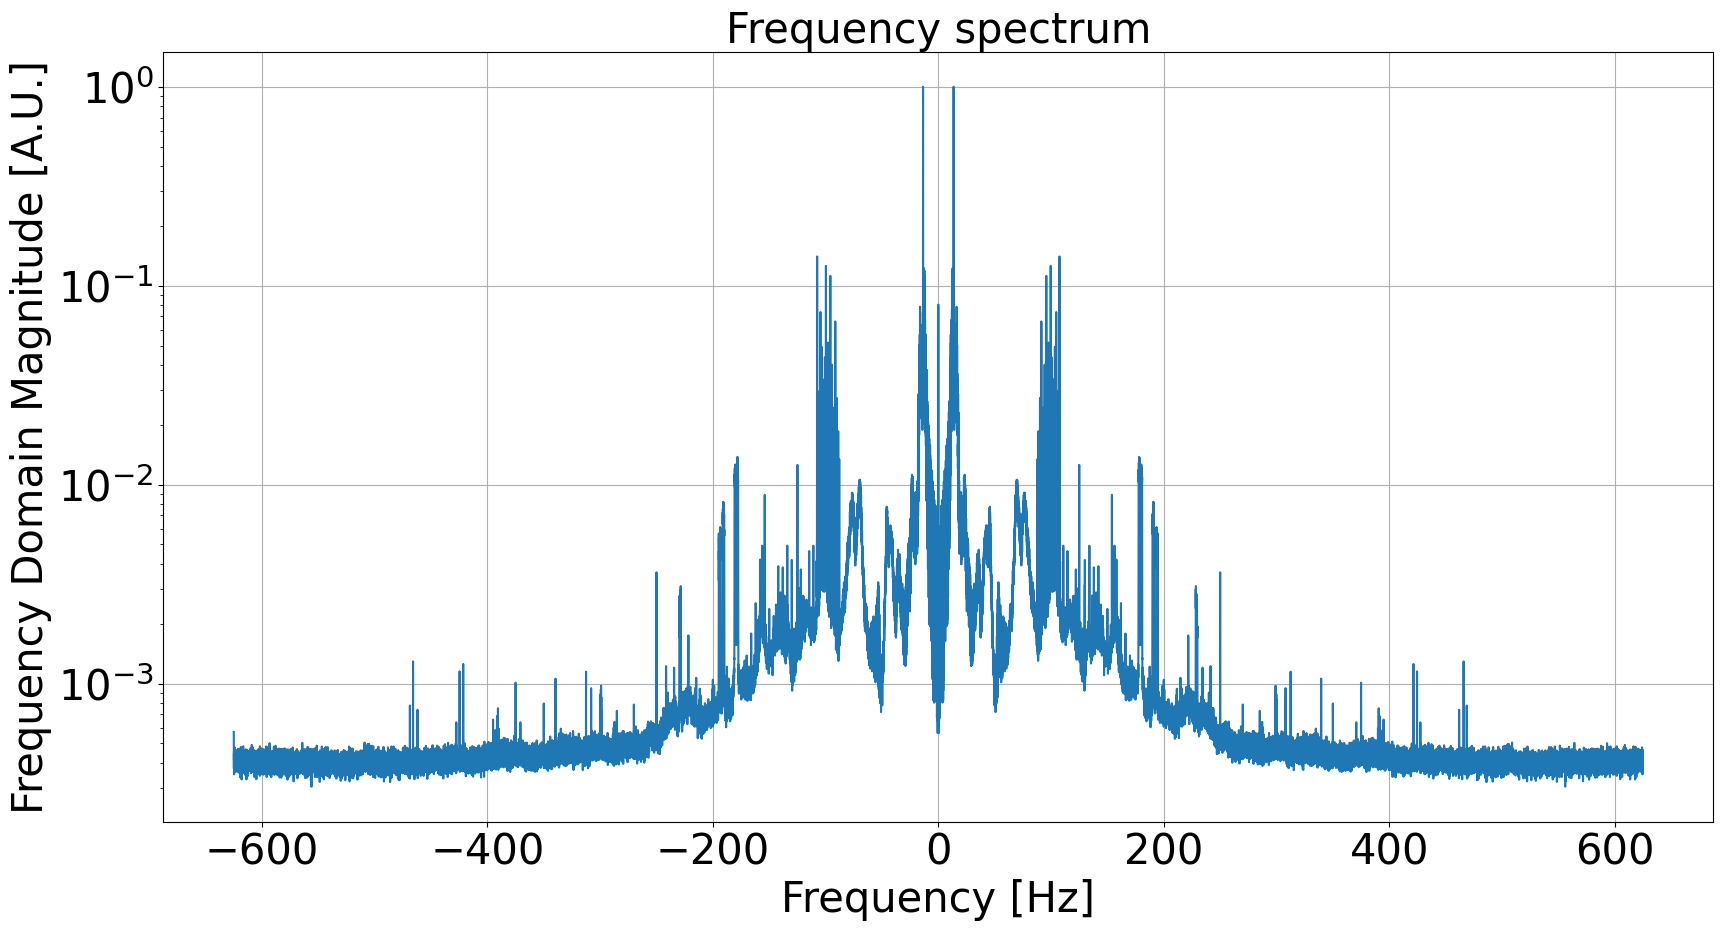

In [93]:
freqs_shifted = fft.fftshift(freqs)
avg_fft_shifted = fft.fftshift(avg_fft)

plt.figure(figsize=(20, 10))
plt.plot(freqs_shifted, np.abs(avg_fft_shifted)/n)

plt.title('Frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [Hz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.semilogy()
plt.grid(True)

#plt.savefig("Results/simple_fft.png", format = "png", bbox_inches="tight")
#plt.savefig("Results/simple_fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

In [94]:
if (N%2 == 0):
    pos_freqs = freqs[:round((N/2))]
    pos_all_magnitudes = all_magnitudes[:, :round((N/2))]
    pos_all_phases = all_phases[:, :round((N/2))]
    pos_all_amplitudes = all_amplitudes[:, :round((N/2))]
else:
    pos_freqs = freqs[:round((N-1)/2 + 1)]
    pos_magnitudes = all_magnitudes[:, :round((N-1)/2 + 1)]
    pos_all_phases = all_phases[:, :round((N-1)/2 + 1)]
    pos_all_amplitudes = all_amplitudes[:, :round((N-1)/2 + 1)]

In [95]:
pos_avg_fft = np.mean(np.abs(pos_all_magnitudes), axis = 0) 

pos_avg_phases = np.mean(pos_all_phases, axis = 0)

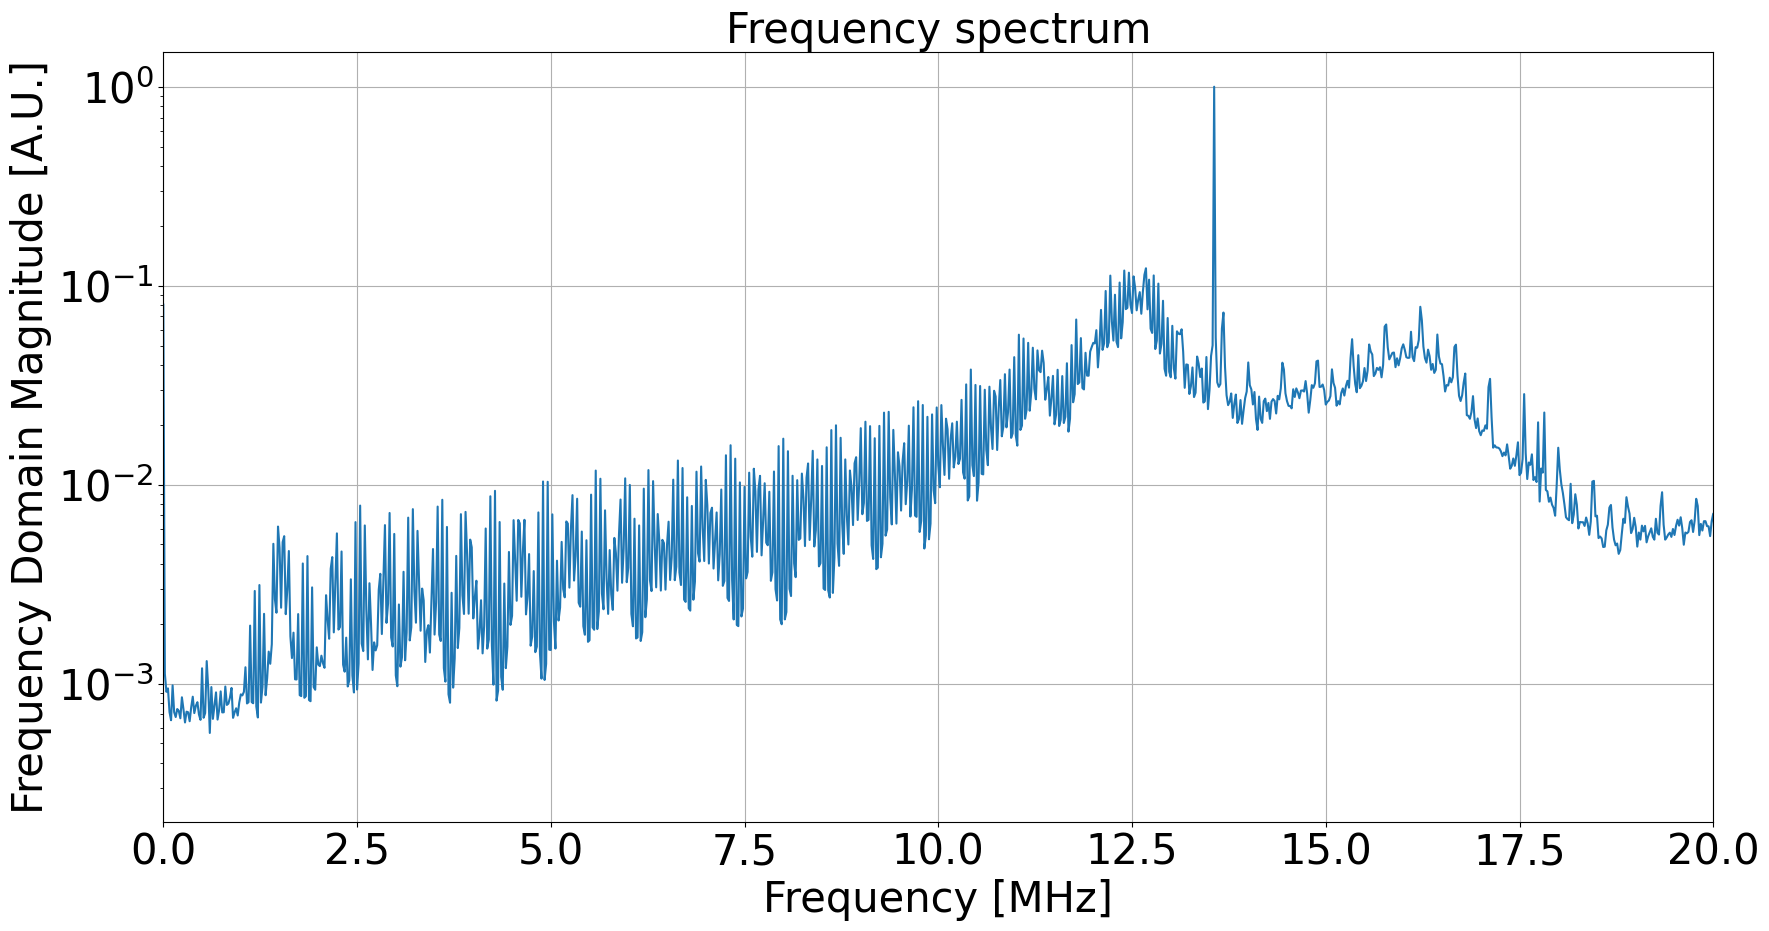

In [96]:
plt.figure(figsize=(20, 10))
#plt.errorbar(freqs, avg_fft_au, yerr = stds_fft, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.plot(pos_freqs, pos_avg_fft/n)

plt.axvline(468.75749336, color = 'red', alpha = 0.2)
plt.title('Frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.semilogy()
plt.xlim(0, 20)
plt.grid(True)
#plt.semilogx()

#plt.savefig("250724_17.23/fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

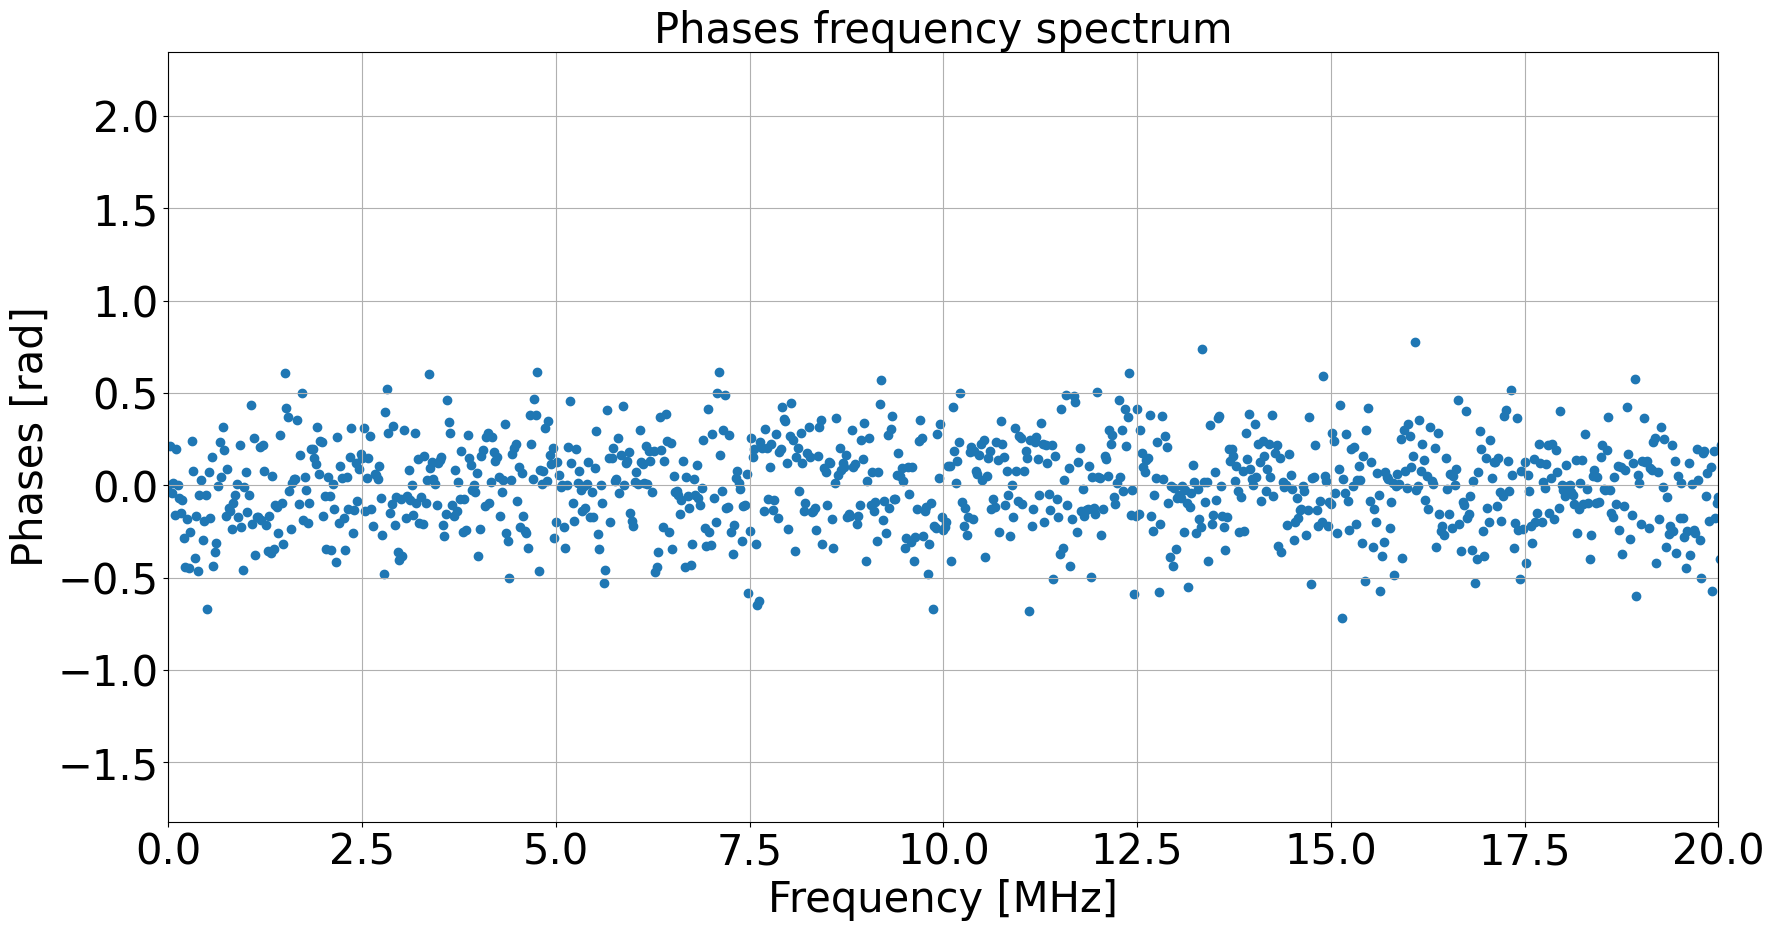

In [97]:
plt.figure(figsize=(20, 10))
#plt.errorbar(freqs, avg_fft_au, yerr = stds_fft, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.scatter(pos_freqs, pos_avg_phases)

plt.title('Phases frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Phases [rad]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
#plt.ylim(-0.5, 0.5)
plt.xlim(0, 20)

#plt.savefig("250724_17.23/fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

In [98]:
f1 = 13
f2 = 14

In [99]:
print(f"positive peak phase: {pos_avg_phases[(pos_freqs >= f1) & (pos_freqs <= f2)][np.argmax(pos_avg_fft[(pos_freqs <= f2) & (pos_freqs >= f1)])]*180/np.pi}")

positive peak phase: 21.62065859970982


## Filtering

In [100]:
avg_filtered_fft, range_avg, peak_f = filtering_func(freqs, all_magnitudes, f1, f2)

fft_in_range: [0.06283239 0.03836001 0.03408982 0.05894811 0.0573373  0.05700084
 0.06036589 0.04658497 0.03064742 0.04018227 0.04000562 0.02854666
 0.03123717 0.03880201 0.02754103 0.02897443 0.04401564 0.04050957
 0.03473978 0.03830908 0.02583741 0.02622025 0.04378405 0.02395749
 0.02985617 0.04429852 0.05011606 1.         0.05478877 0.03267317
 0.03099009 0.03202164 0.06089555 0.07325747 0.03913789 0.02814406
 0.02508365 0.02611231 0.02871157 0.02163785 0.02546372 0.0283484
 0.02039627 0.02136207 0.02659739 0.02020158 0.02367976 0.02724602
 0.02937242 0.04111193 0.04111193 0.02937242 0.02724602 0.02367976
 0.02020158 0.02659739 0.02136207 0.02039627 0.0283484  0.02546372
 0.02163785 0.02871157 0.02611231 0.02508365 0.02814406 0.03913789
 0.07325747 0.06089555 0.03202164 0.03099009 0.03267317 0.05478877
 1.         0.05011606 0.04429852 0.02985617 0.02395749 0.04378405
 0.02622025 0.02583741 0.03830908 0.03473978 0.04050957 0.04401564
 0.02897443 0.02754103 0.03880201 0.03123717 0.02

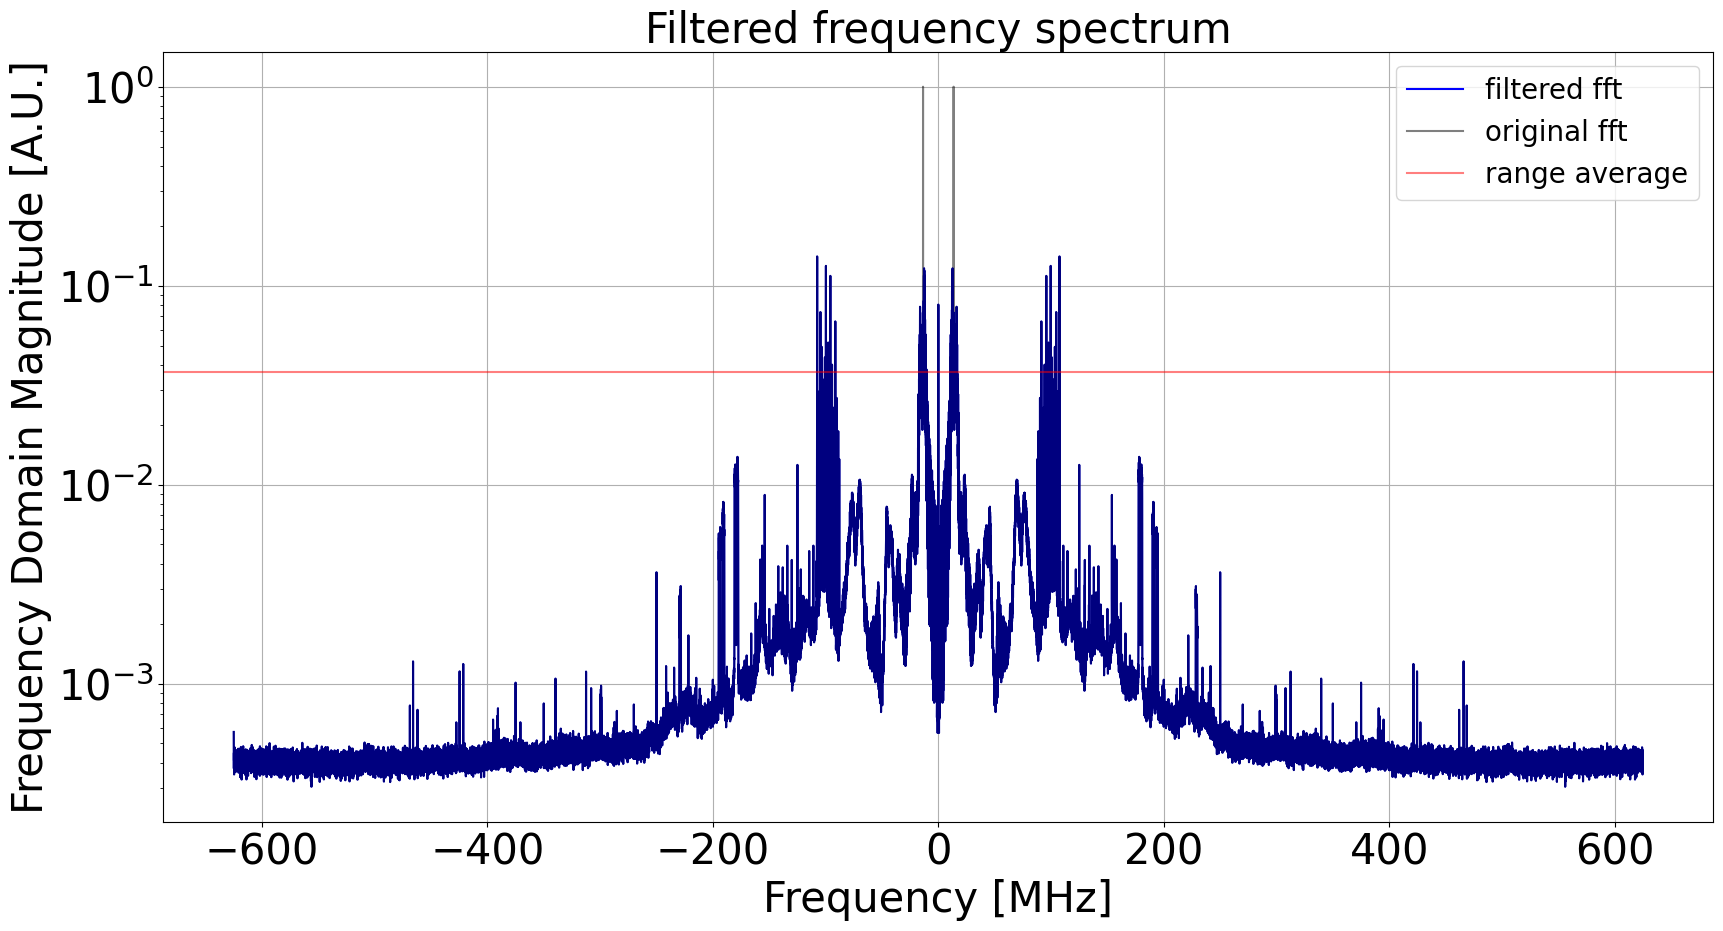

In [101]:
avg_filtered_fft_shifted = fft.fftshift(avg_filtered_fft)

plt.figure(figsize=(20, 10))
plt.plot(freqs_shifted, avg_filtered_fft_shifted/n, color = 'blue', label = 'filtered fft')
plt.plot(freqs_shifted, avg_fft_shifted/n, alpha = 0.5, color = 'k', label = 'original fft')
plt.axhline(range_avg, color = 'red', alpha = 0.5, label = 'range average')

#plt.axvline(465.97762683, color = 'red')
plt.title('Filtered frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
plt.semilogy()
#plt.xlim(-f2, -f1)
plt.legend(loc = 'best', fontsize = 20)
#plt.semilogx()

#plt.savefig("250724_17.23/fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

In [102]:
if (N%2 == 0):
    pos_avg_filtered_fft = avg_filtered_fft[:round((N/2))]
else:
    pos_avg_filtered_fft = avg_filtered_fft[:round((N-1)/2 + 1)]

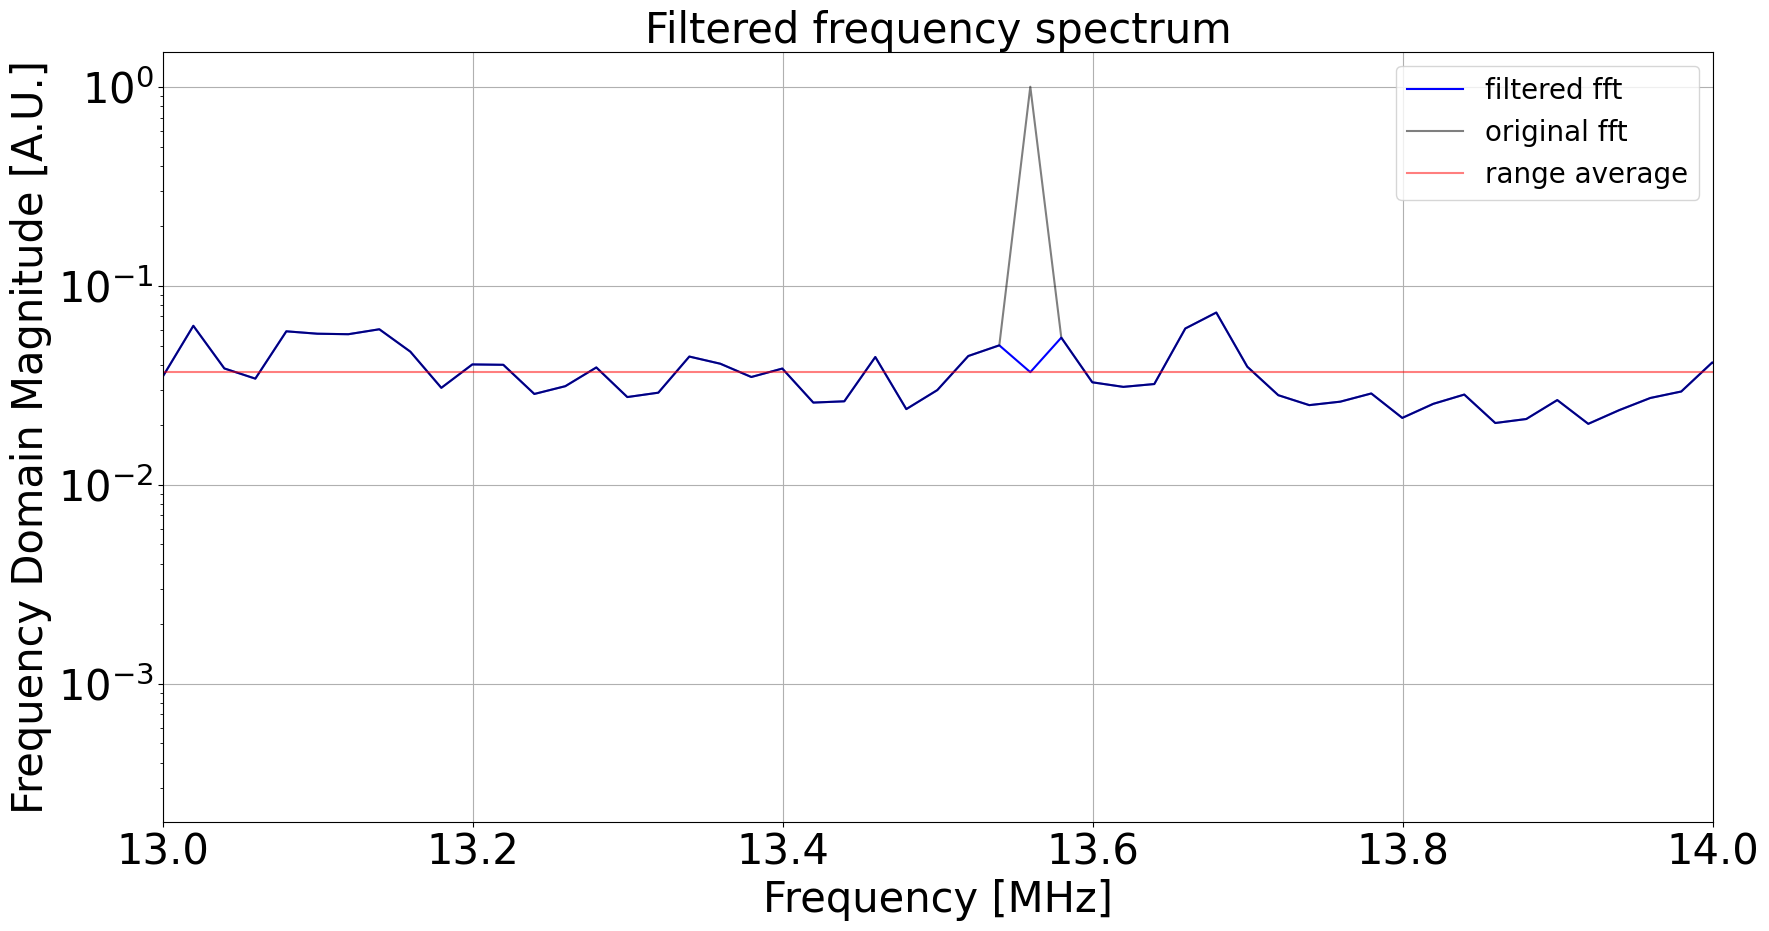

In [127]:
plt.figure(figsize=(20, 10))
plt.plot(pos_freqs, pos_avg_filtered_fft/n, color = 'blue', label = 'filtered fft')
plt.plot(pos_freqs, pos_avg_fft/n, alpha = 0.5, color = 'k', label = 'original fft')
plt.axhline(range_avg, color = 'red', alpha = 0.5, label = 'range average')

plt.title('Filtered frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
plt.semilogy()
plt.xlim(f1, f2)
plt.legend(loc = 'best', fontsize = 20)
#plt.semilogx()

#plt.savefig("250724_17.23/fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

## IFFT

In [104]:
#times_ifft = np.arange(N) / f_s #SAME as times, just checking
avg_filtered_amplitudes = fft.ifft(avg_filtered_fft) #input/output = 2D complex array OR you can do the ifft of the avg_filtered_fft, but it would mean passing a real number, not good for phases

## Compare to reconstructed waveform

In [105]:
avg_reconstructed_wf = fft.ifft(avg_fft)

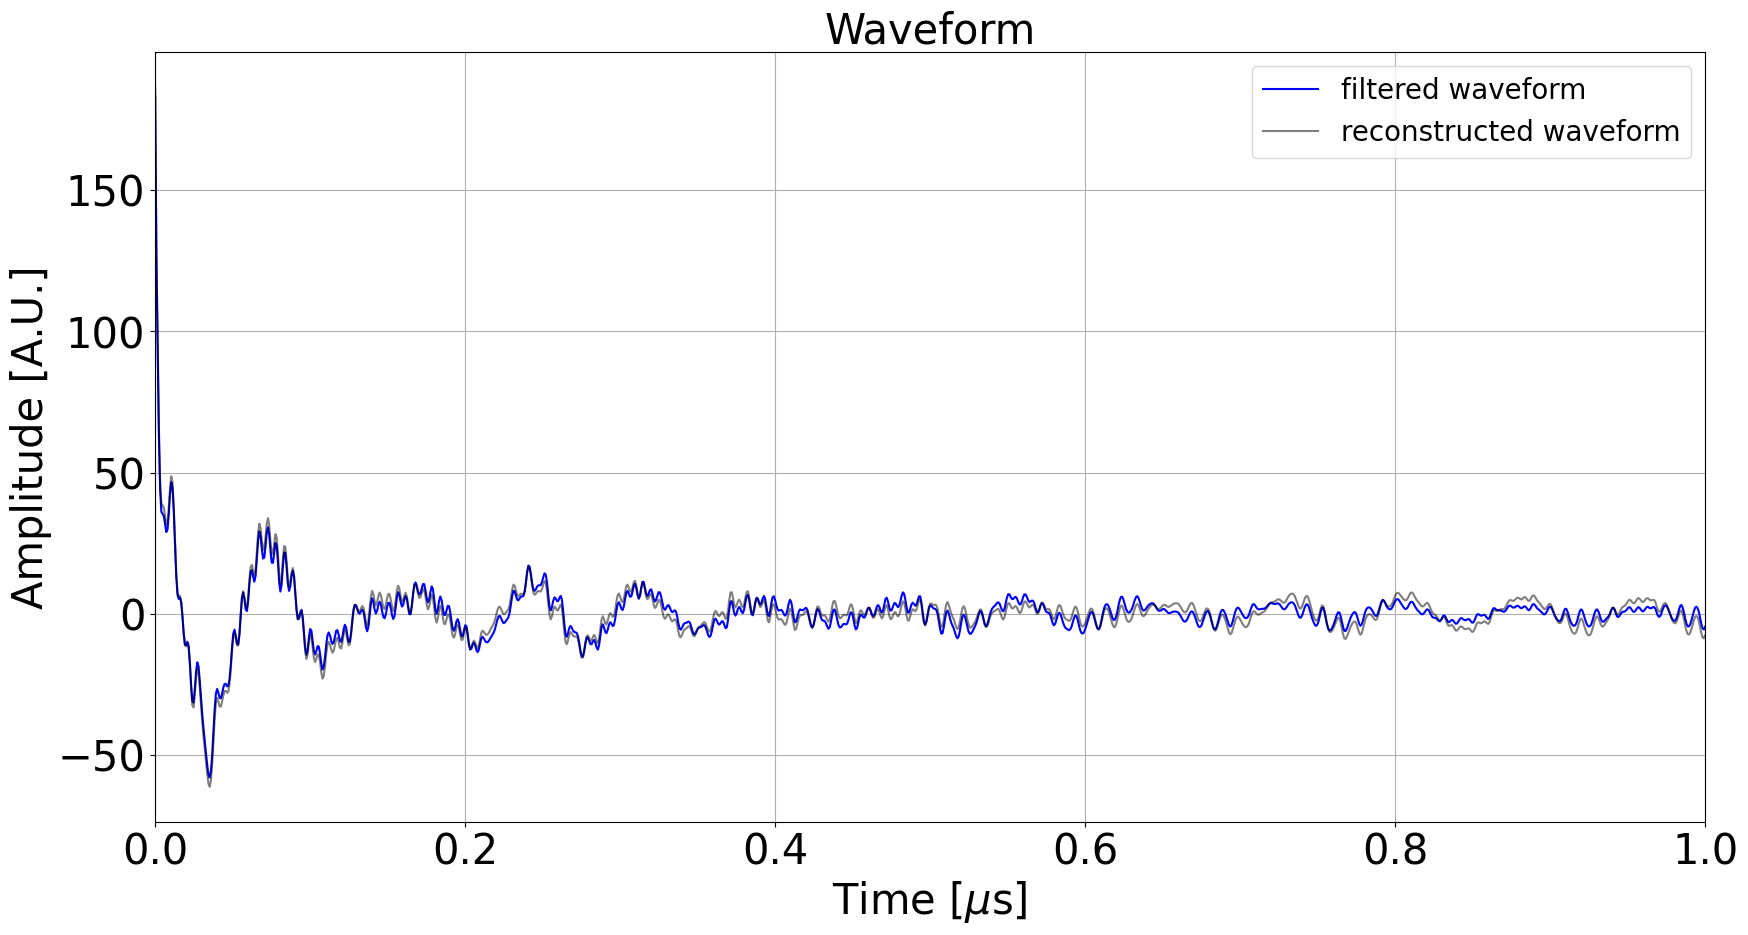

In [106]:
plt.figure(figsize = (20, 10))
plt.plot(times, avg_filtered_amplitudes.real, label = 'filtered waveform', color = 'blue')
plt.plot(times, avg_reconstructed_wf.real, label = 'reconstructed waveform', color = 'k', alpha = 0.5)

plt.title('Waveform', fontsize = 30)
plt.xlabel(r'Time [$\mu$s]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Amplitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
plt.xlim(0, 1)
plt.legend(loc = 'best', fontsize = 20)

#plt.savefig("Results/simple_ifft.png", format = "png", bbox_inches="tight")
#plt.savefig("Results/simple_ifft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

In [107]:
avg_noise_wf = avg_reconstructed_wf - avg_filtered_amplitudes #is mathematically the same to subtract the averages and subtract element per element

In [108]:
A = max(avg_noise_wf.real)
phi = pos_avg_phases[pos_freqs == peak_f[0]]
#print(phi*180/np.pi)
f = peak_f[0]
coswave = A*np.cos(f * 2*np.pi*times + phi)
print(np.arccos((coswave)[times == 0]/A)*180/(np.pi))

[21.6206586]


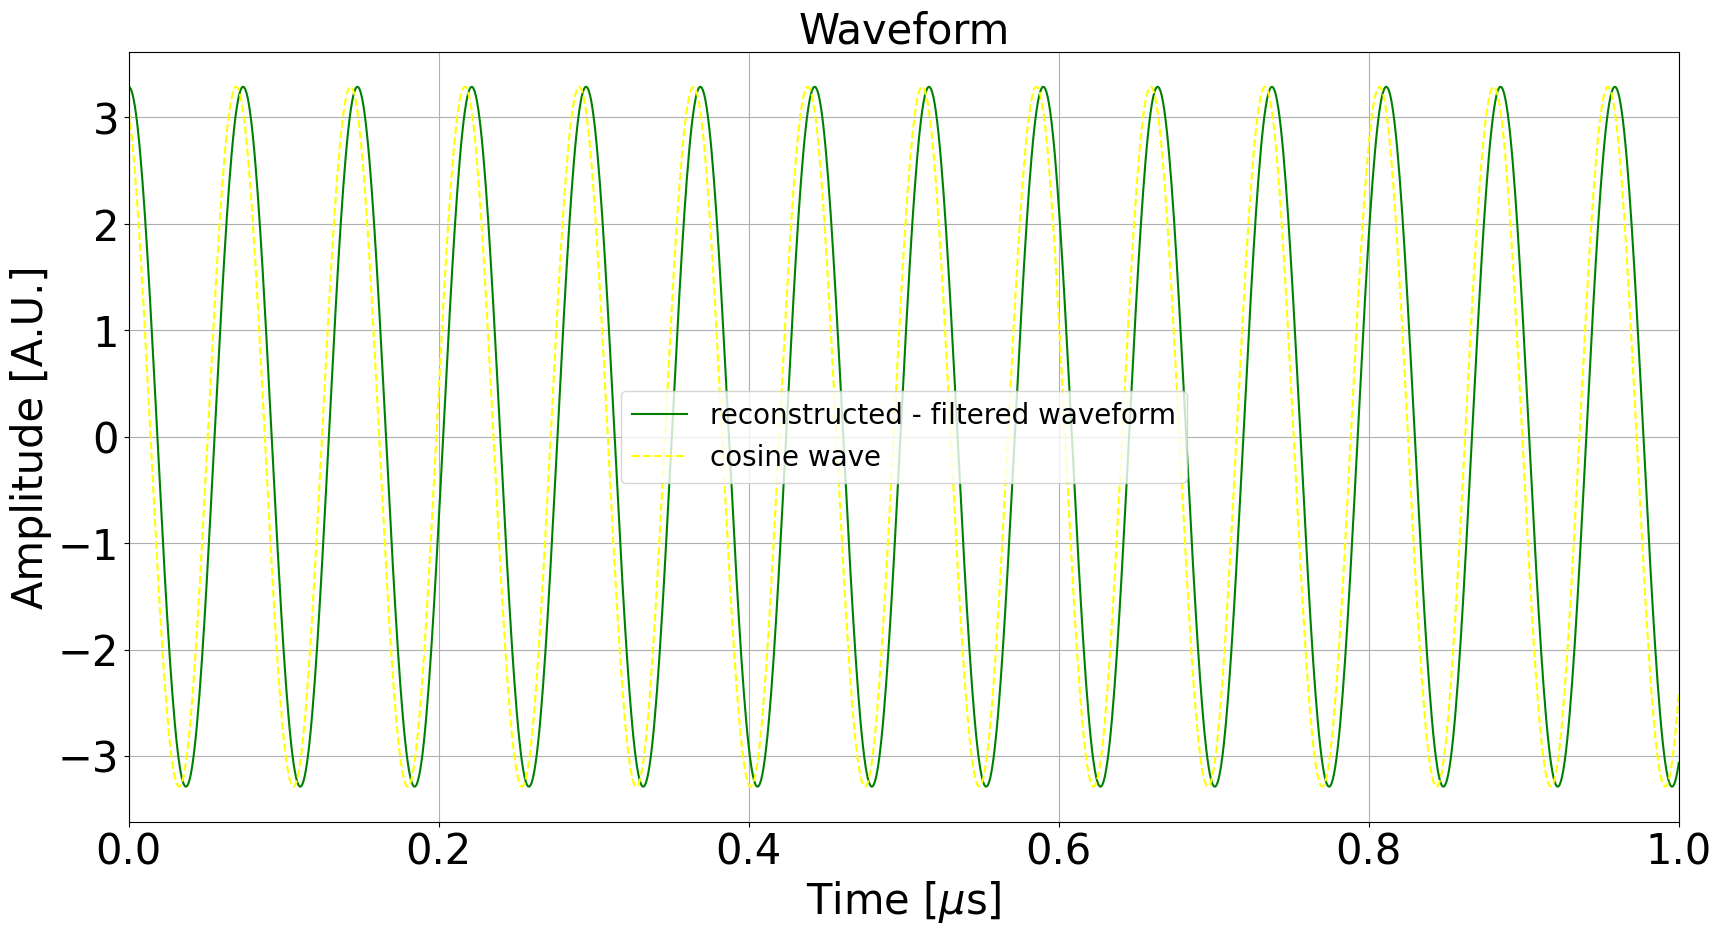

In [109]:
plt.figure(figsize = (20, 10))
plt.plot(times, avg_noise_wf.real, label = 'reconstructed - filtered waveform', color = 'green')
plt.plot(times, coswave, label = 'cosine wave', color = 'yellow', linestyle = '--')

plt.title('Waveform', fontsize = 30)
plt.xlabel(r'Time [$\mu$s]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Amplitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
plt.xlim(0, 1)
plt.legend(loc = 'best', fontsize = 20)

#plt.savefig("Results/simple_ifft.png", format = "png", bbox_inches="tight")
#plt.savefig("Results/simple_ifft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

In [110]:
print(np.arccos((avg_noise_wf.real)[times == 0]/A)*180/np.pi)
print(np.arccos((coswave)[times == 0]/A)*180/np.pi)

[0.]
[21.6206586]


# Make sure reconstructed waveform and original waveform are not the same

In [111]:
avg_amplitudes = np.mean(all_amplitudes, axis = 0)

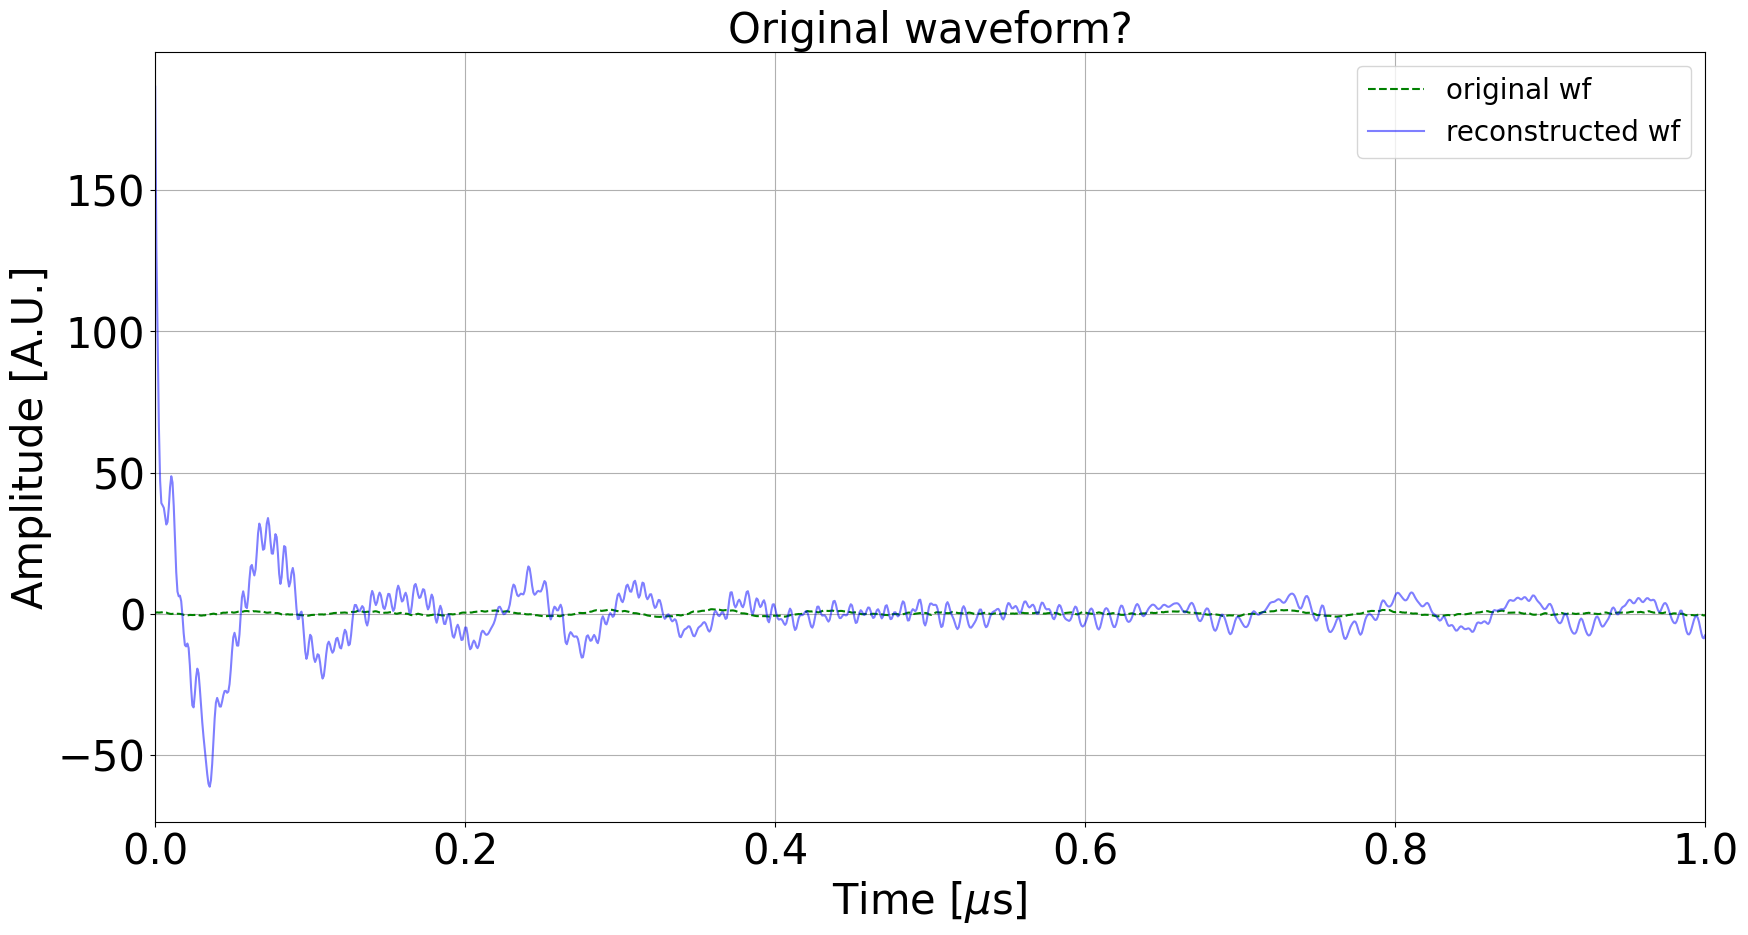

In [117]:
plt.figure(figsize = (20, 10))
plt.plot(times, avg_amplitudes, label = 'original wf', color = 'green', linestyle = '--')
plt.plot(times, avg_reconstructed_wf.real, label = 'reconstructed wf', color = 'blue', alpha = 0.5)

plt.title('Original waveform?', fontsize = 30)
plt.xlabel(r'Time [$\mu$s]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Amplitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
plt.xlim(0, 1)
plt.legend(loc = 'best', fontsize = 20)

#plt.savefig("Results/simple_ifft.png", format = "png", bbox_inches="tight")
#plt.savefig("Results/simple_ifft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

In [113]:
#depending on the range f1, f2 the phase changes

# Plot reconstructed fft

In [118]:
avg_reconstructed_filtered_fft = fft.ifft(avg_filtered_amplitudes)

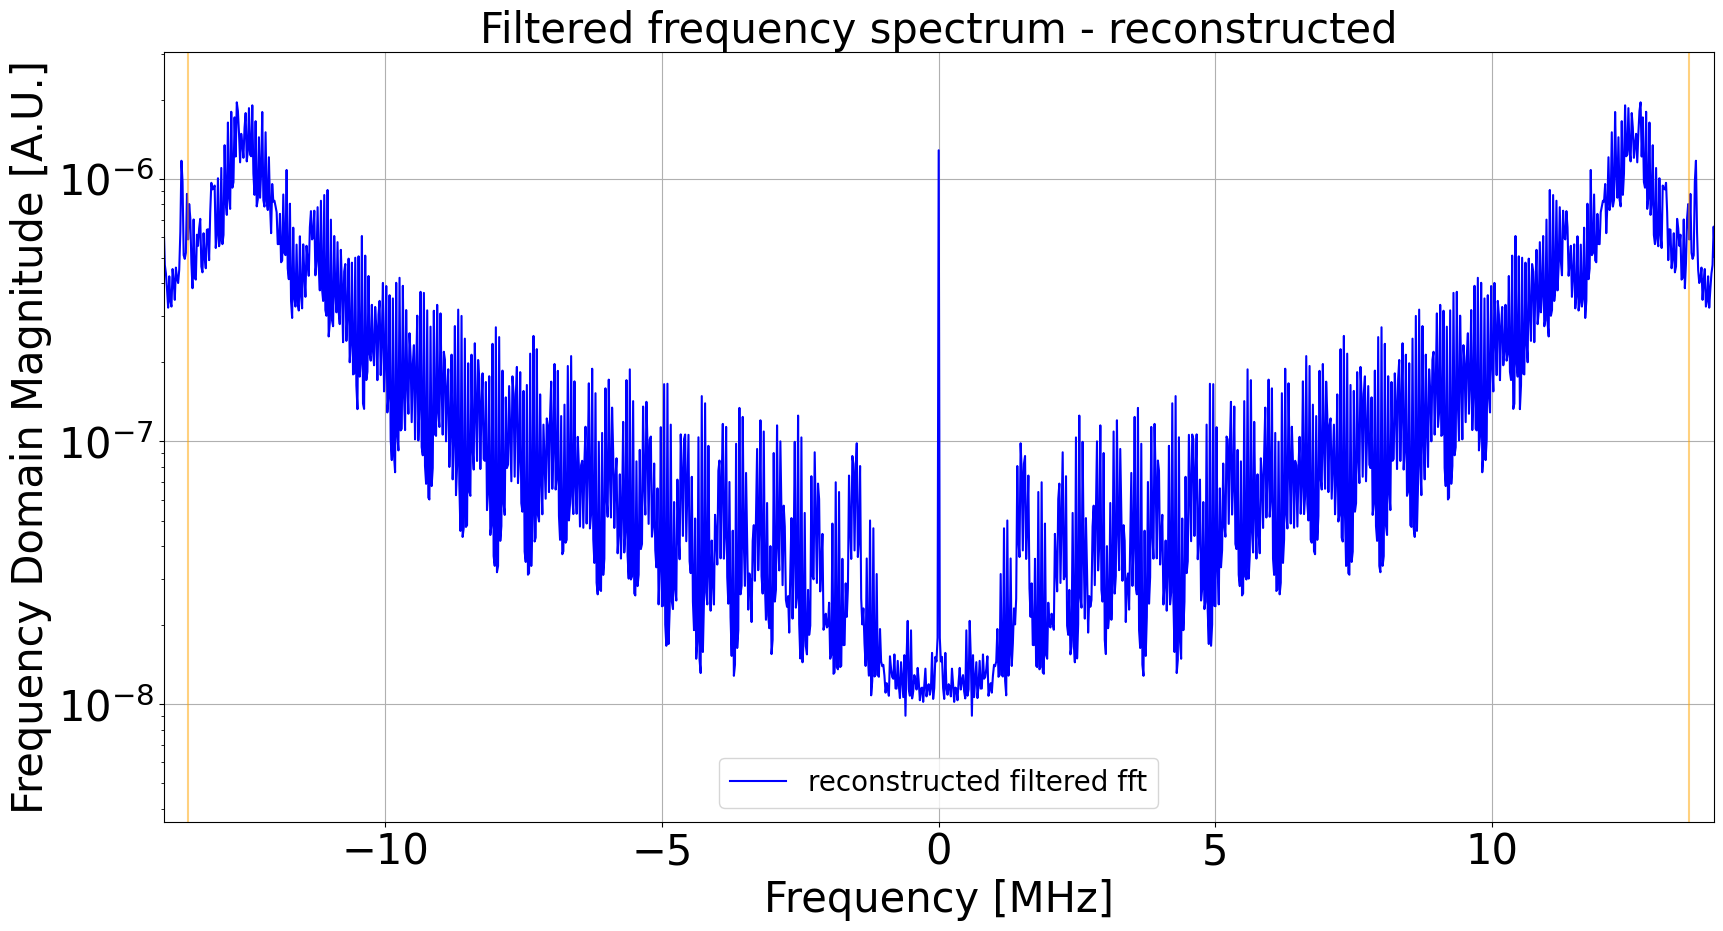

In [119]:
avg_reconstructed_filtered_fft_shifted = fft.fftshift(avg_reconstructed_filtered_fft) 

plt.figure(figsize=(20, 10))
plt.plot(freqs_shifted, np.abs(avg_reconstructed_filtered_fft_shifted)/n, color = 'blue', label = 'reconstructed filtered fft')
plt.axvline(peak_f[0], color = 'orange', alpha = 0.5)
plt.axvline(peak_f[1], color = 'orange', alpha = 0.5)

plt.title('Filtered frequency spectrum - reconstructed', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
plt.xlim(-f2, f2)
plt.legend(loc = 'best', fontsize = 20)
plt.semilogy()

#plt.savefig("250724_17.23/fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

In [120]:
if (N%2 == 0):
    pos_avg_reconstructed_filtered_fft = avg_reconstructed_filtered_fft[:round((N/2))]
else:
    pos_avg_reconstructed_filtered_fft = avg_reconstructed_filtered_fft[:round((N-1)/2 + 1)]

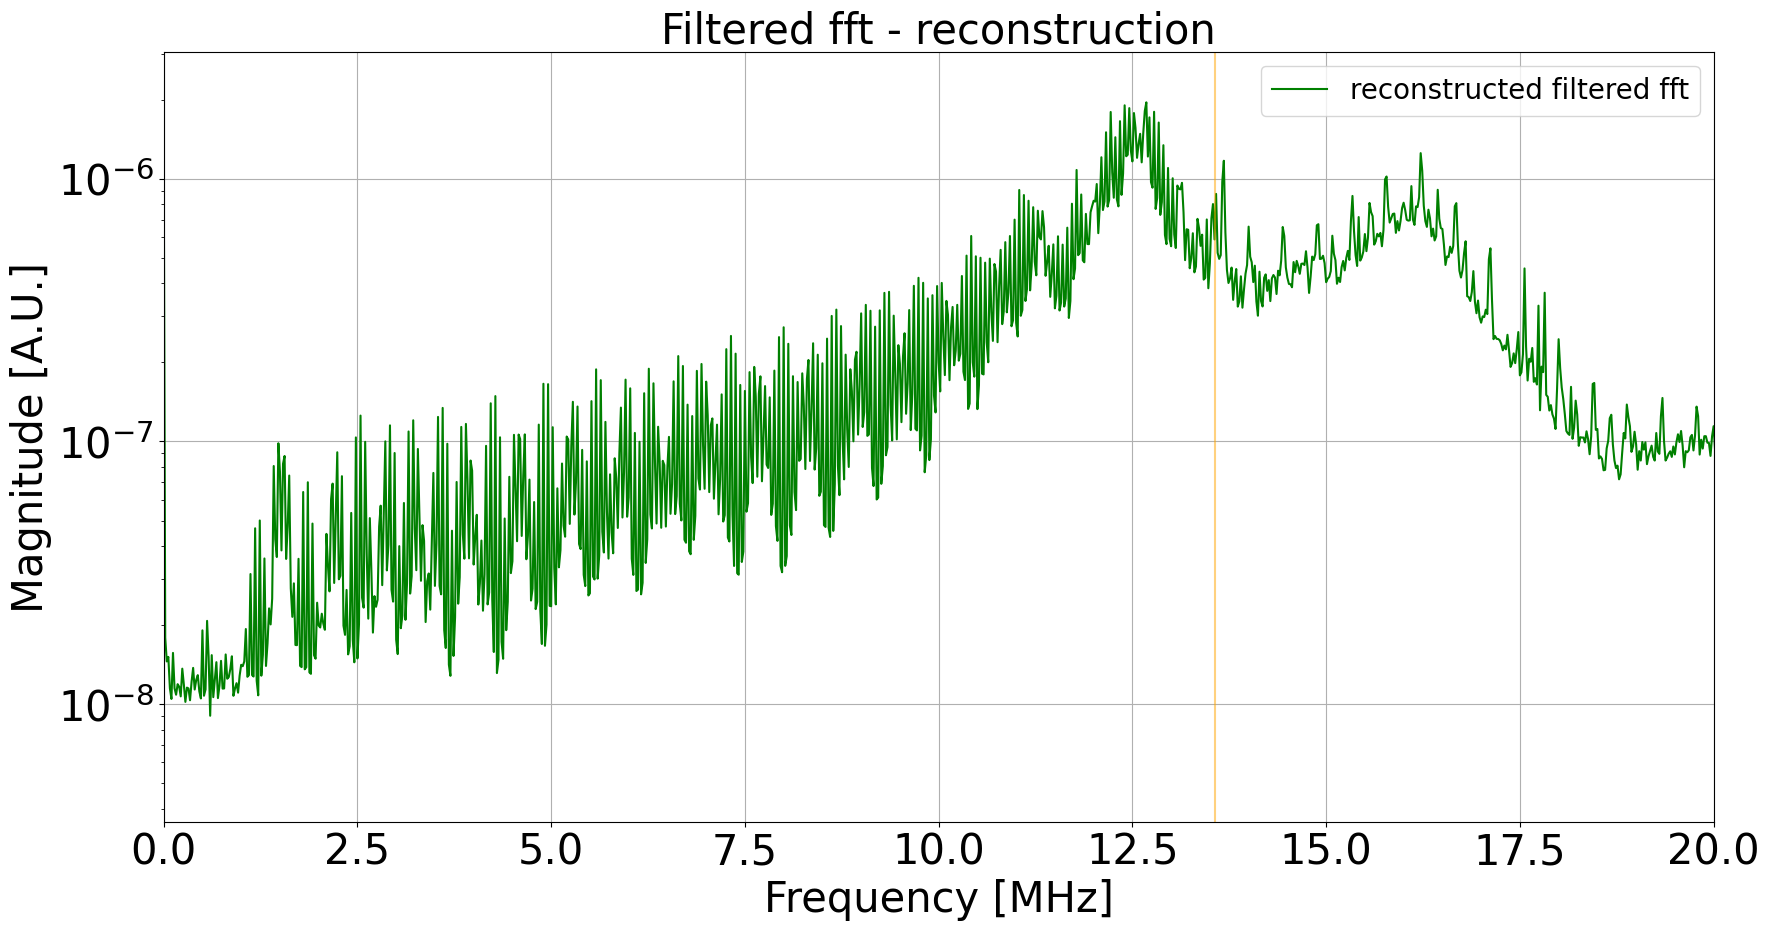

In [125]:
plt.figure(figsize = (20, 10))
plt.plot(pos_freqs, np.abs(pos_avg_reconstructed_filtered_fft)/n, label = 'reconstructed filtered fft', color = 'green')
plt.axvline(peak_f[0], color = 'orange', alpha = 0.5)

plt.title('Filtered fft - reconstruction', fontsize = 30)
plt.xlabel(r'Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Magnitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
plt.semilogy()

plt.xlim(0, 20)
plt.legend(loc = 'best', fontsize = 20)

#plt.savefig("Results/simple_ifft.png", format = "png", bbox_inches="tight")
#plt.savefig("Results/simple_ifft.pdf", format = "pdf", bbox_inches="tight")
plt.show()